### STA-LSTM model - multiclass training - 300 coordinates

#### Environment preparation

In [1]:
# Montowanie Google Drive
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [2]:
import os

# Przejście do katalogu głównego
%cd /content

# Klonowanie repo
!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [3]:
# Upewnij się, że nazwa użytkownika i repozytorium są poprawne
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

# Tworzenie poprawnego adresu URL (format: https://<TOKEN>@github.com/...)
REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

# Klonowanie
!git clone {REPO_URL}

# Wejście do katalogu
%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 344 (delta 34), reused 53 (delta 20), pack-reused 277 (from 1)
Receiving objects: 100% (344/344), 12.43 MiB | 17.77 MiB/s, done.
Resolving deltas: 100% (158/158), done.
/content/automatic-pain-recognition


In [ ]:
# Instalacja wymaganych bibliotek
!pip install -r requirements.txt

In [5]:
import sys
import os

# Dodaj katalog główny projektu do ścieżki systemowej
sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### STA-LSTM model - multiclass training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.STA_LSTM import STA_LSTM

In [7]:
MAX_SEQUENCE_LENGTH = 46
NUM_FEATURES = 300
NUM_CLASSES = 5
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.3
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.9

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [11]:
best_100_landmarks = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

feature_indices_x = best_100_landmarks * 3
feature_indices_y = best_100_landmarks * 3 + 1
feature_indices_z = best_100_landmarks * 3 + 2

# Interleave to get [X1, Y1, Z1, X2, Y2, Z2, ...]
best_300_features = np.stack([feature_indices_x, feature_indices_y, feature_indices_z], axis=1).flatten()


In [12]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_300_features,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

In [13]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (46, 300), y: 0
tensor([[0.1507, 0.1288, 0.1142, 0.1074, 0.2043, 0.0947, 0.1404, 0.0928],
        [0.1488, 0.1293, 0.1180, 0.1079, 0.2146, 0.1028, 0.1382, 0.0917],
        [0.1507, 0.1252, 0.1187, 0.1093, 0.2105, 0.1028, 0.1401, 0.0886]])

Single sample idx=0 from split=val
x shape: (46, 300), y: 0
tensor([[0.1483, 0.1156, 0.1151, 0.1027, 0.1887, 0.0901, 0.1374, 0.0823],
        [0.1522, 0.1143, 0.1157, 0.1043, 0.1852, 0.0900, 0.1415, 0.0816],
        [0.1524, 0.1143, 0.1155, 0.1045, 0.1854, 0.0897, 0.1416, 0.0817]])

Single sample idx=0 from split=test
x shape: (46, 300), y: 0
tensor([[0.1401, 0.1400, 0.1036, 0.0984, 0.2080, 0.0833, 0.1307, 0.1012],
        [0.1392, 0.1376, 0.1043, 0.0974, 0.2055, 0.0839, 0.1297, 0.0993],
        [0.1393, 0.1381, 0.1052, 0.0976, 0.2081, 0.0852, 0.1300, 0.0995]])


In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 46, 300]) torch.Size([16])
torch.Size([16, 46, 300]) torch.Size([16])
torch.Size([16, 46, 300]) torch.Size([16])


#### Model preparation

In [15]:
model = STA_LSTM(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_sta_lstm_5_classes_300_coord.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [17]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [18]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : STA_LSTM
  Input Features        : 300
  Hidden Size           : 128
  Num Layers            : 2
  Bidirectional         : True
  Dropout (LSTM)        : 0.3
  Num Parameters        : 947634

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 5e-05
  Weight Decay (L2)     : 0.005

--- Training Flow ---
  Batch Size            : 16
  Num Epochs            : 200
  Device                : cuda



In [19]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_sta_lstm_5_classes_300_coord.pt (metric=0.2000)
Epoch 1/200 | Time 19.60s | Train loss 1.6645 | Train acc 0.2028 | Val loss 1.6226 | Val acc 0.2000
Epoch 2/200 | Time 9.67s | Train loss 1.6450 | Train acc 0.1959 | Val loss 1.6152 | Val acc 0.1992
Epoch 3/200 | Time 6.34s | Train loss 1.6352 | Train acc 0.1925 | Val loss 1.6116 | Val acc 0.2000
Epoch 4/200 | Time 6.59s | Train loss 1.6307 | Train acc 0.1992 | Val loss 1.6092 | Val acc 0.2000
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_sta_lstm_5_classes_300_coord.pt (metric=0.2185)
Epoch 5/200 | Time 6.26s | Train loss 1.6272 | Train acc 0.2030 | Val loss 1.6150 | Val acc 0.2185
Epoch 6/200 | Time 6.69s | Train loss 1.6225 | Train acc 0.2148 | Val loss 1.6088 | Val acc 0.2177
Epoch 7/200 | Time 6.16s | Train loss 1.6183 | Train acc 0.2179 | Val loss 1.6

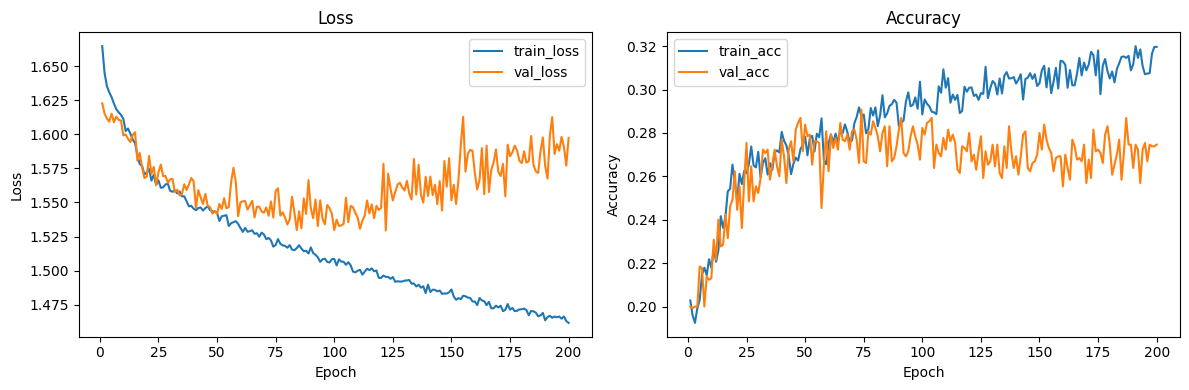

In [20]:
trainer.plot_history()

#### Evaluate

In [21]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [22]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [23]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_sta_lstm_5_classes_300_coord.pt
Test Loss: 1.5484
Test Accuracy: 0.3062

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.26      0.71      0.38       260
     Klasa 1       0.31      0.08      0.13       260
     Klasa 2       0.20      0.10      0.13       260
     Klasa 3       0.26      0.12      0.16       260
     Klasa 4       0.48      0.53      0.50       260

    accuracy                           0.31      1300
   macro avg       0.30      0.31      0.26      1300
weighted avg       0.30      0.31      0.26      1300

Confusion matrix:
 [[184  20  25  20  11]
 [163  22  25  30  20]
 [162   7  25  24  42]
 [114   7  32  30  77]
 [ 78  15  19  11 137]]
